In [1]:
# Run this in a Kaggle cell
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python-headless
!pip install -q scikit-image
!pip install -q pandas matplotlib

# **🧱 BLOCK 1 — Imports**

In [2]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models # <-- AJOUT DE MODELS ICI
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import warnings
warnings.filterwarnings("ignore")

# **🧱 BLOCK 2 — GLOBAL PARAMETERS**

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 128
BATCH_SIZE = 64 
NUM_WORKERS = 4

# On augmente Z_DIM pour donner plus de "mémoire" aux détails fins
Z_DIM = 512 
BETA = 1.0  

EPOCHS = 100
LR_GEN = 2e-4
LR_DISC = 1e-5  # On ralentit le Discriminateur pour stabiliser le GAN
BETAS = (0.5, 0.999)
LABEL_SMOOTH = 0.8 

BASE_PATH = "/kaggle/input/resized-2015-2019-blindness-detection-images"
TRAIN_CSV = f"{BASE_PATH}/labels/trainLabels19.csv"
TRAIN_IMG_DIR = f"{BASE_PATH}/resized train 19"
MODEL_SAVE_PATH = "/kaggle/working/final_vaegan_aptos.pth"

# **🧱 BLOCK 3 — PREPROCESSING (BEN GRAHAM)**

In [4]:
def ben_graham_preprocessing(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)
    return image

# **🧱 BLOCK 4 — TRANSFORMS**

In [5]:
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3) # Normalisation [-1, 1]
])

# **🧱 BLOCK 5 — DATASET CLASS**

In [6]:
class APTOSDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        df = pd.read_csv(csv_file)
        df['path'] = df.iloc[:, 0].apply(lambda x: os.path.join(img_dir, str(x) + ".jpg"))
        self.data = df[df['path'].apply(os.path.exists)].reset_index(drop=True)
        self.transform = transform
        print(f"✅ Chargement de {len(self.data)} images.")

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.loc[idx, 'path']
        image = cv2.imread(img_path)
        image = ben_graham_preprocessing(image)
        if self.transform: image = self.transform(image)
        return image, torch.tensor(self.data.iloc[idx, 1], dtype=torch.long)

# **🧱 BLOCK 6 — DATALOADER**

In [7]:
dataset = APTOSDataset(TRAIN_CSV, TRAIN_IMG_DIR, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

✅ Chargement de 3662 images.


# **🧱 BLOCK 7 — β-VAE + GAN MODELS**

In [8]:
class BetaVAE_GAN(nn.Module):
    def __init__(self, z_dim=512):
        super(BetaVAE_GAN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256 * 8 * 8, z_dim)
        self.fc_var = nn.Linear(256 * 8 * 8, z_dim)
        self.decoder_input = nn.Linear(z_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh() 
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def forward(self, x):
        feat = self.encoder(x)
        mu, logvar = self.fc_mu(feat), self.fc_var(feat)
        z = self.reparameterize(mu, logvar)
        return self.decoder(self.decoder_input(z)), mu, logvar

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 8, 1, 0), nn.Sigmoid()
        )
    def forward(self, x): return self.model(x).view(-1, 1)

# **🧱 BLOCK 8 — INITIALIZATION**

In [9]:
# Modèle de perte pour la netteté des textures (Perceptual Loss)
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        # On utilise les 16 premières couches de VGG16 pour capturer les détails fins
        vgg = models.vgg16(weights='DEFAULT').features[:16].eval().to(DEVICE)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, x, y):
        # Comparaison des textures profondes
        return F.mse_loss(self.vgg(x), self.vgg(y))

# Initialisation des modèles et critères
model = BetaVAE_GAN(Z_DIM).to(DEVICE)
disc = Discriminator().to(DEVICE)
perceptual_criterion = VGGPerceptualLoss() # <--- Correction de l'erreur
bce_loss = nn.BCELoss()

# Optimiseurs
opt_gen = torch.optim.Adam(model.parameters(), lr=LR_GEN, betas=BETAS)
opt_disc = torch.optim.Adam(disc.parameters(), lr=LR_DISC, betas=BETAS)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 235MB/s]


# **🧱 BLOCK 9 — METRICS (PSNR / SSIM)**

In [10]:
def compute_quality_metrics(real_batch, recon_batch):
    psnrs, ssims = [], []
    real_imgs = (real_batch.detach().cpu().numpy() * 0.5 + 0.5)
    recon_imgs = (recon_batch.detach().cpu().numpy() * 0.5 + 0.5)
    for i in range(real_imgs.shape[0]):
        r, rc = np.transpose(real_imgs[i], (1, 2, 0)), np.transpose(recon_imgs[i], (1, 2, 0))
        psnrs.append(psnr_metric(r, rc, data_range=1.0))
        ssims.append(ssim_metric(r, rc, data_range=1.0, channel_axis=2))
    return np.mean(psnrs), np.mean(ssims)

# **🧱 BLOCK 🔟 — TRAINING LOOP**

In [11]:
history = {'PSNR': [], 'SSIM': []}

for epoch in range(EPOCHS):
    epoch_m = {'D': [], 'Recon': [], 'PSNR': [], 'SSIM': []}
    model.train(); disc.train()
    
    for imgs, _ in dataloader:
        imgs = imgs.to(DEVICE)
        b_size = imgs.size(0)
        
        # --- Train Discriminator ---
        opt_disc.zero_grad()
        recon, mu, logvar = model(imgs)
        d_loss = (bce_loss(disc(imgs), torch.full((b_size, 1), LABEL_SMOOTH).to(DEVICE)) + 
                  bce_loss(disc(recon.detach()), torch.zeros(b_size, 1).to(DEVICE))) / 2 
        d_loss.backward(); opt_disc.step()

        # --- Train Generator ---
        opt_gen.zero_grad()
        r_loss = F.l1_loss(recon, imgs, reduction='mean') 
        k_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        g_adv = bce_loss(disc(recon), torch.ones(b_size, 1).to(DEVICE))
        
        # AJOUT : Perte perceptuelle pour restaurer les vaisseaux sanguins
        p_loss = perceptual_criterion(recon, imgs)
        
        # Somme pondérée : on donne beaucoup de poids aux détails (p_loss)
        g_loss = r_loss + (BETA * k_loss) + g_adv + (10.0 * p_loss)
        g_loss.backward(); opt_gen.step()
        
        p, s = compute_quality_metrics(imgs, recon)
        epoch_m['D'].append(d_loss.item()); epoch_m['Recon'].append(r_loss.item())
        epoch_m['PSNR'].append(p); epoch_m['SSIM'].append(s)

    history['PSNR'].append(np.mean(epoch_m['PSNR']))
    history['SSIM'].append(np.mean(epoch_m['SSIM']))
    print(f"Epoch {epoch:03d} | D: {np.mean(epoch_m['D']):.3f} | PSNR: {np.mean(epoch_m['PSNR']):.2f} | SSIM: {np.mean(epoch_m['SSIM']):.4f}")

Epoch 000 | D: 1.448 | PSNR: 12.43 | SSIM: 0.0203
Epoch 001 | D: 1.073 | PSNR: 13.21 | SSIM: 0.0256
Epoch 002 | D: 1.017 | PSNR: 13.69 | SSIM: 0.0295
Epoch 003 | D: 0.991 | PSNR: 14.02 | SSIM: 0.0340
Epoch 004 | D: 0.952 | PSNR: 14.42 | SSIM: 0.0412
Epoch 005 | D: 0.901 | PSNR: 14.86 | SSIM: 0.0492
Epoch 006 | D: 0.827 | PSNR: 15.28 | SSIM: 0.0567
Epoch 007 | D: 0.735 | PSNR: 15.75 | SSIM: 0.0656
Epoch 008 | D: 0.678 | PSNR: 16.55 | SSIM: 0.0801
Epoch 009 | D: 0.617 | PSNR: 17.27 | SSIM: 0.0953
Epoch 010 | D: 0.576 | PSNR: 17.83 | SSIM: 0.1079
Epoch 011 | D: 0.528 | PSNR: 18.43 | SSIM: 0.1236
Epoch 012 | D: 0.493 | PSNR: 19.29 | SSIM: 0.1511
Epoch 013 | D: 0.488 | PSNR: 20.26 | SSIM: 0.1894
Epoch 014 | D: 0.492 | PSNR: 21.38 | SSIM: 0.2444
Epoch 015 | D: 0.511 | PSNR: 22.46 | SSIM: 0.3091
Epoch 016 | D: 0.520 | PSNR: 23.29 | SSIM: 0.3679
Epoch 017 | D: 0.512 | PSNR: 23.63 | SSIM: 0.3943
Epoch 018 | D: 0.491 | PSNR: 23.84 | SSIM: 0.4072
Epoch 019 | D: 0.469 | PSNR: 23.98 | SSIM: 0.4180


# **🧱 BLOCK 1️⃣1️⃣ — VISUALIZATION**

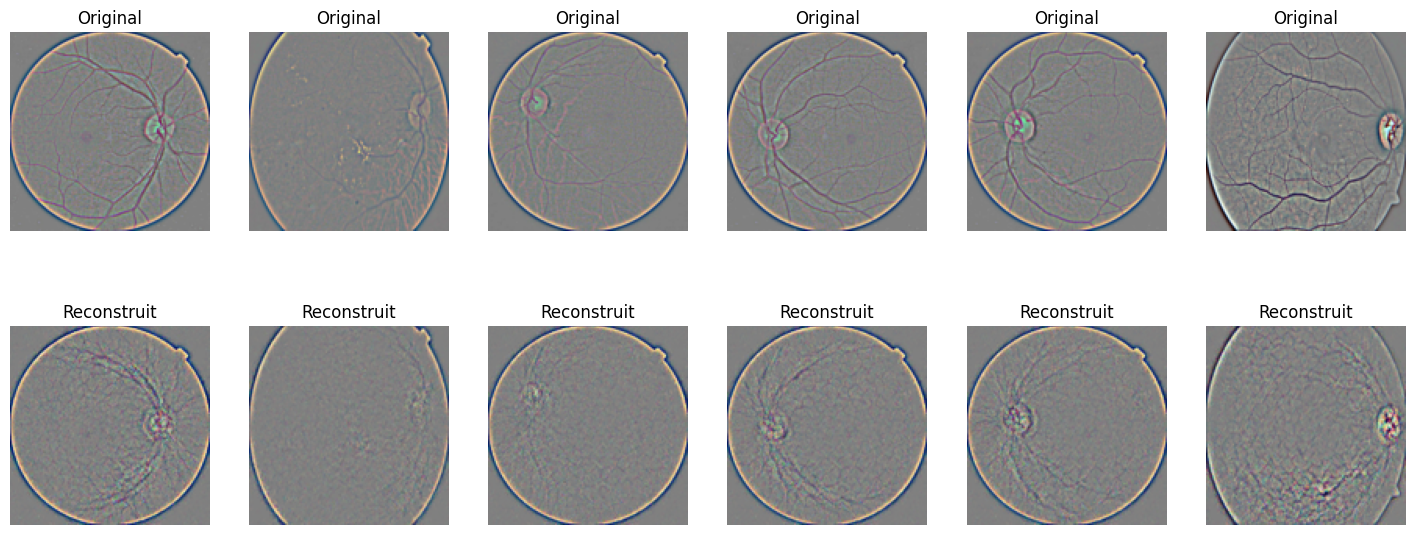

In [12]:
def plot_results(model, loader):
    model.eval()
    real, _ = next(iter(loader))
    real = real[:6].to(DEVICE)
    with torch.no_grad():
        recon, _, _ = model(real)
    
    real, recon = real.cpu() * 0.5 + 0.5, recon.cpu() * 0.5 + 0.5
    fig, axes = plt.subplots(2, 6, figsize=(18, 7))
    for i in range(6):
        axes[0, i].imshow(real[i].permute(1, 2, 0))
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(recon[i].permute(1, 2, 0))
        axes[1, i].set_title("Reconstruit")
        axes[1, i].axis('off')
    plt.show()

plot_results(model, dataloader)

# **🧱 BLOCK 1️⃣2️⃣ — SAVE MODEL**

In [13]:
torch.save({
    'vae_state_dict': model.state_dict(),
    'disc_state_dict': disc.state_dict(),
    'params': {'z_dim': Z_DIM, 'beta': BETA}
}, MODEL_SAVE_PATH)
print(f"💾 Sauvegardé avec succès vers {MODEL_SAVE_PATH}")

💾 Sauvegardé avec succès vers /kaggle/working/final_vaegan_aptos.pth


# **🧱 BLOCK 1️⃣3️⃣ — Minority Class Generato**

In [14]:
from tqdm import tqdm

def generate_balanced_samples(checkpoint_path, output_root="/kaggle/working/augmented_dataset"):
    print(f"Chargement du modèle : {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    
    gen_model = BetaVAE_GAN(z_dim=checkpoint['params']['z_dim']).to(DEVICE)
    gen_model.load_state_dict(checkpoint['vae_state_dict'])
    gen_model.eval()

    generation_plan = {1: 500, 3: 800, 4: 1000}

    with torch.no_grad():
        for class_id, num_images in generation_plan.items():
            class_dir = os.path.join(output_root, f"class_{class_id}")
            os.makedirs(class_dir, exist_ok=True)
            for i in tqdm(range(num_images), desc=f"Classe {class_id}"):
                z = torch.randn(1, checkpoint['params']['z_dim']).to(DEVICE)
                synth = gen_model.decoder(gen_model.decoder_input(z))
                synth = (synth.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5) * 255
                cv2.imwrite(os.path.join(class_dir, f"s_{i}.jpg"), cv2.cvtColor(synth.astype(np.uint8), cv2.COLOR_RGB2BGR))

generate_balanced_samples(MODEL_SAVE_PATH)

Chargement du modèle : /kaggle/working/final_vaegan_aptos.pth


Classe 4: 100%|██████████| 1000/1000 [00:01<00:00, 896.84it/s]


# **🧱 BLOCK 1️⃣4️⃣ — Training Dynamics Visualization**

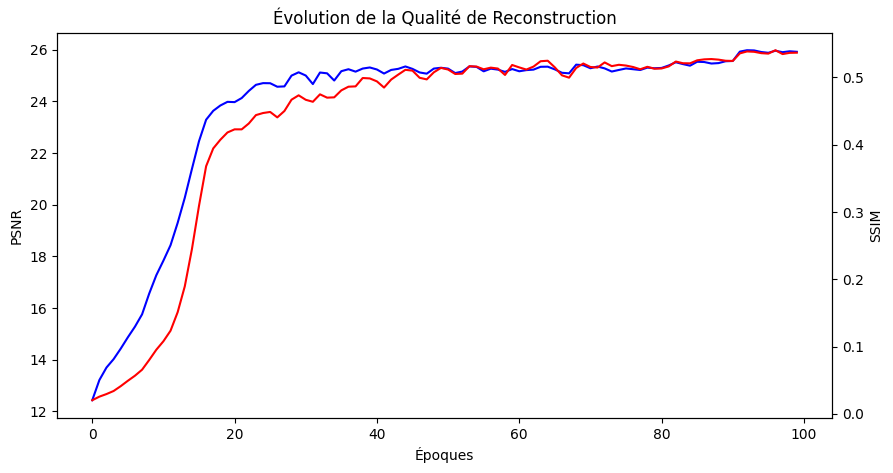

In [15]:
def plot_metrics(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['PSNR'], label='PSNR (dB)', color='blue')
    plt.ylabel('PSNR'); plt.xlabel('Époques')
    plt.twinx()
    plt.plot(history['SSIM'], label='SSIM', color='red')
    plt.ylabel('SSIM')
    plt.title("Évolution de la Qualité de Reconstruction")
    plt.show()

# Assurez-vous que votre BLOCK 10 remplit le dictionnaire 'history'
plot_metrics(history)

# **🧱 BLOCK 1️⃣5️⃣ — Custom Reconstruction Test**

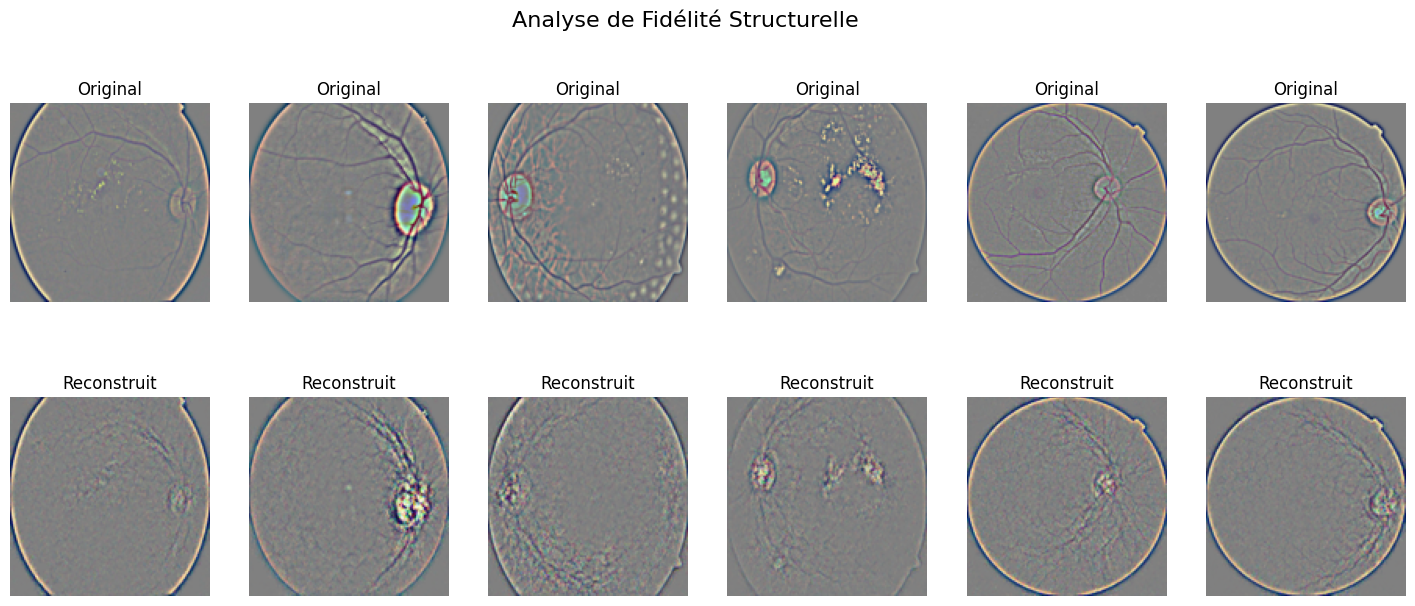

In [16]:
def plot_reconstructions(model, loader, n=6):
    model.eval()
    real, _ = next(iter(loader))
    real = real[:n].to(DEVICE)
    with torch.no_grad():
        recon, _, _ = model(real)
    
    real_img = (real.cpu() * 0.5 + 0.5).permute(0, 2, 3, 1).numpy()
    recon_img = (recon.cpu() * 0.5 + 0.5).permute(0, 2, 3, 1).numpy()
    
    fig, axes = plt.subplots(2, n, figsize=(18, 7))
    for i in range(n):
        axes[0, i].imshow(real_img[i]); axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        axes[1, i].imshow(recon_img[i]); axes[1, i].axis('off')
        axes[1, i].set_title("Reconstruit")
    plt.suptitle("Analyse de Fidélité Structurelle", fontsize=16)
    plt.show()

plot_reconstructions(model, dataloader)